In [1]:
try:
    import os
    from os import listdir
    from os.path import join
    import pickle
    from queue import Empty, Queue
    from math import exp
    from math import log10
    import torch.nn.functional as F
    from matplotlib import pyplot as plt
    import numpy as np
    from PIL import Image
    import random
    import threading
    from threading import Thread
    import torch
    from torch import nn
    from torch.autograd import Variable
    import torch.optim as optim
    from torch.utils.tensorboard import SummaryWriter
    from torchvision.models.vgg import vgg19
    from tqdm import tqdm
    from libs.SGDR import CosineAnnealingWarmRestarts

except ImportError as e:
    print(e)
    raise ImportError

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

In [4]:
#nn.Sequential(*list(vgg19(pretrained=True).features)[:]).eval()

In [5]:
def find_files(dataset_dir):
    image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir)]
    return image_filenames

In [6]:
data_index_fname = 'data/data_index.p'
data_index_val_fname = 'data/data_index_val.p'

In [7]:
class thread_killer(object):    
    """
    Boolean object for signaling a worker thread to terminate
    """
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [8]:
def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
   
    """
    Threaded worker for pre-processing input data.
    tokill is a thread_killer object that indicates whether a thread should be terminated
    dataset_generator is the training/validation dataset generator
    batches_queue is a limited size thread-safe Queue instance.
    """
    while tokill() == False:
        for batch, (batch_images, batch_targets) in enumerate(dataset_generator):
            #We fill the queue with new fetched batch until we reach the max size.
            batches_queue.put((batch, (batch_images, batch_targets)), block=True)
            if tokill() == True:
                return

In [9]:
def threaded_cuda_batches(tokill,cuda_batches_queue,batches_queue):
    
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue is the queue that fetches numpy cpu tensors.
    cuda_batches_queue receives numpy cpu tensors and transfers them to GPU space.
    """
    while tokill() == False:
        batch, (batch_images, batch_targets) = batches_queue.get(block=True)
        
        batch_images = torch.from_numpy(batch_images)
        batch_labels = torch.from_numpy(batch_targets)
        
        batch_images = Variable(batch_images).cuda()
        batch_labels = Variable(batch_labels).cuda()
        
        cuda_batches_queue.put((batch, (batch_images, batch_labels)), block=True)
        if tokill() == True:
            return

In [10]:
class threadsafe_iter:
    
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

In [11]:
def get_path_i(paths_count):
    
    """
    Cyclic generator of paths indices
    """   
    current_path_id = 0
    while True:
        yield current_path_id
        current_path_id  = (current_path_id + 1) % paths_count

In [12]:
class InputGenerator:
    def __init__(self, data_index_fname, batch_size, debug=False):
        print('loading files index...')
        with open(data_index_fname, 'rb') as f:
            data_dicts = pickle.load(f)
            
        lores_datafiles = [f for f in find_files('data/LoRes/Arrays/FIELD/')]
        lores_datafiles.sort()
        hires_datafiles = [f for f in find_files('data/HiRes/Arrays/FIELD/')]
        hires_datafiles.sort()
        
        data_dict_lores = dict(zip(lores_datafiles, [np.load(f, mmap_mode = 'r') for f in lores_datafiles]))
        data_dict_hires = dict(zip(hires_datafiles, [np.load(f, mmap_mode = 'r') for f in hires_datafiles]))
        
        self.data_index_fname = data_index_fname
        self.batch_size = batch_size
        self.debug = debug
        self.index = 0
        self.init_count = 0
        self.dicts = data_dicts
        self.dict_lores = data_dict_lores
        self.dict_hires = data_dict_hires
        print('examples number: %d' % len(self.dicts))

        self.lock = threading.Lock()  # mutex for input path
        self.yield_lock = threading.Lock()  # mutex for generator yielding of batch
        self.path_id_generator = threadsafe_iter(get_path_i(len(self.dicts)))
        self.imgs = []
        self.trgs = []      

    #def preprocess_img(self, fn):
    #    img = None
    #    if self.args.memcache:
    #        if fn in self.images_cached:
    #            img = self.images_cached[fn]
    #    if img is None:
    #        img = cv2.imread(fn)
    #        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #        if self.args.memcache:
    #            self.images_cached[fn] = img
     #   return img

    def shuffle(self):
        random.shuffle(self.dicts)

    def __iter__(self):
        while True:
            # In the start of each epoch we shuffle the data paths
            with self.lock:
                if (self.init_count == 0):
                    self.shuffle()
                    self.imgs, self.trgs = [], []
                    self.init_count = 1
            # Iterates through the input paths in a thread-safe manner
            for path_id in self.path_id_generator:
                img_fn = self.dicts[path_id]["data_fname_lores"]
                img_id = self.dicts[path_id]["data_lores_idx"]
                img = self.dict_lores[img_fn][img_id]
                
                trg_fn = self.dicts[path_id]["data_fname_hires"]
                trg_id = self.dicts[path_id]["data_hires_idx"]
                trg = self.dict_hires[trg_fn][trg_id]

                #img = self.preprocess_img(img_fn)
                #trg = self.targets_transformer(trgs)
                #trg = trg.astype(np.float32)

                # Concurrent access by multiple threads to the lists below
                with self.yield_lock:
                    if (len(self.imgs)) < self.batch_size:
                        self.imgs.append(img)
                        self.trgs.append(trg)
                    if len(self.imgs) % self.batch_size == 0:
                        imgs_f32 = np.float32(self.imgs)
                        trgs_f32 = np.float32(self.trgs)
                        yield (imgs_f32, trgs_f32)
                        self.imgs, self.trgs = [], []
            # At the end of an epoch we re-init data-structures
            with self.lock:
                random.shuffle(self.dicts)
                self.init_count = 0

    def __call__(self):
        return self.__iter__()

In [13]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

In [14]:
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    #.mm - Performs a matrix multiplication of the matrice
    
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

In [15]:
def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

In [16]:
def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [17]:
# LOSS

In [18]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        #vgg = vgg19(pretrained=True)
        #vgg = vgg.cuda()
        #loss_network = nn.Sequential(*list(vgg.features)[:20]).eval()
        # A sequential container. Modules will be added to it in the order they are passed in the constructor. 
        # Alternatively, an ordered dict of modules can also be passed in.
        #for param in loss_network.parameters():
        #    param.requires_grad = False
        #self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()

    def forward(self, fake_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - fake_labels)
        
        # Perception Loss
        #perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        
        #generator_loss = image_loss + 0.005 * adversarial_loss + 0.01 * perception_loss
        generator_loss = image_loss + 0.005 * adversarial_loss
        return generator_loss

In [19]:
#class DiscriminatorLoss(nn.Module):
    #def __init__(self):
    #    super(DiscriminatorLoss, self).__init__()

    #def forward(self, fake_labels, real_labels):
    #    discriminator_loss = 1 - real_labels + fake_labels
    #    return discriminator_loss

In [20]:
g_loss = GeneratorLoss()
#d_loss = DiscriminatorLoss()

In [21]:
# MODEL

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),nn.PReLU())
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),nn.BatchNorm2d(64))
        self.block8 = UpsampleBLock(64, 5)
        self.block9 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        block9 = self.block9(block8)

        return (torch.tanh(block9) + 1) / 2

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [24]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        
        # Rearranges elements in a tensor of shape (∗,C×r^2,H,W) 
        # to a tensor of shape (*, C, H x r, W x r).
        # This is useful for implementing efficient sub-pixel convolution with a stride of 1/r
        
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

In [26]:
# TRAIN

In [27]:
#netG = Generator()
#print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

In [28]:
#netD = Discriminator()
#print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

In [29]:
def train_epoch(netG: nn.Module, netD: nn.Module, optimizerG: torch.optim.Optimizer, optimizerD: torch.optim.Optimizer, 
                epoch: int, NUM_EPOCHS: int, cuda_batches_queue: Queue,
                generator_criterion: callable, 
                #discriminator_criterion: callable,
                STEPS_PER_EPOCH: int, batch_size: int):
    
    netG.train()
    netD.train()
    term_columns = os.get_terminal_size().columns
    pbar = tqdm(total=STEPS_PER_EPOCH, ncols=min(term_columns,180))
    
    mse_metrics = 0.0
    ssim_metrics = 0.0
    psnr_metrics = 0.0
    batch_sizes = 0
    running_results_g_loss = 0.0
    running_results_d_loss = 0.0
    ssims = 0

    for batch_idx in range(STEPS_PER_EPOCH):
        _, (img, trg) = cuda_batches_queue.get(block=True)
        
        batch_sizes += batch_size
        
        img[:,0,:,:] = (img[:,0,:,:]+40)/80
        img[:,1,:,:] = (img[:,1,:,:]+40)/80
        img[:,2,:,:] = (img[:,2,:,:]-940)/120
        
        trg[:,0,:,:] = (trg[:,0,:,:]+40)/80
        trg[:,1,:,:] = (trg[:,1,:,:]+40)/80       
        trg[:,2,:,:] = (trg[:,2,:,:]-940)/120
        
        g_update_first = True

        fake_img = netG(img)
        fake_out = netD(fake_img).mean()
        g_loss = generator_criterion(fake_out, fake_img, trg)
        
        netG.zero_grad()
        g_loss.backward(retain_graph = True)
        optimizerG.step()     
    
        real_out = netD(trg).mean()
        fake_out = netD(fake_img.detach()).mean()
        d_loss = 1 - real_out + fake_out

        netD.zero_grad()
        d_loss.backward()
        optimizerD.step()
        
        running_results_g_loss += g_loss.item() * batch_size
        running_results_d_loss += d_loss.item() * batch_size
        
        batch_mse = ((fake_img - trg) ** 2).data.mean()
        mse_metrics += batch_mse * batch_size
        batch_ssim = ssim(fake_img, trg).item()
        ssims += batch_ssim * batch_size
        psnr_metrics = 10 * log10((trg.max()**2) / (mse_metrics / batch_sizes))
        ssim_metrics = ssims / batch_sizes
        
        pbar.update(1)
        pbar.set_postfix_str('Train Epoch: %d [%d/%d (%.2f%%)]\tG_Loss: %.6f; D_Loss: %.6f; MSE: %.6f; SSIM: %.6f; PSNR: %.6f' % (epoch,
                                                                                                                                 batch_idx+1,
                                                                                                                                 STEPS_PER_EPOCH,
                                                                                                                                 100. *(batch_idx+1) / STEPS_PER_EPOCH,
                                                                                                                                 running_results_g_loss/batch_sizes,
                                                                                                                                 running_results_d_loss/batch_sizes,
                                                                                                                                 mse_metrics,
                                                                                                                                 ssim_metrics,
                                                                                                                                 psnr_metrics))
        if batch_idx >= STEPS_PER_EPOCH-1:
            break
            
    g_loss = running_results_g_loss/batch_sizes
    d_loss = running_results_d_loss/batch_sizes
    
    #ssim_metrics = float(((ssim_metrics / STEPS_PER_EPOCH)))
    #psnr_metrics = float(((psnr_metrics / STEPS_PER_EPOCH)))
    mse_metrics = float(mse_metrics.cpu())
    
    pbar.set_postfix_str('Train Epoch: %d; G_Loss: %.6f; D_Loss: %.6f; MSE: %.6f; SSIM: %.6f; PSNR: %.6f' % (epoch,
                                                                                                             g_loss,
                                                                                                             d_loss,
                                                                                                             mse_metrics,
                                                                                                             ssim_metrics,
                                                                                                             psnr_metrics))
 #   for tag, param in model.named_parameters():
#        TBwriter.add_histogram('grad/%s'%tag, param.grad.data.cpu().numpy(), epoch)
 #       TBwriter.add_histogram('weight/%s' % tag, param.data.cpu().numpy(), epoch)

    # if (args.debug & (epoch % 10 == 0)):
    #     TBwriter.add_images('input', img, epoch)

#    if args.debug:
#        for mname in activations.keys():
#            TBwriter.add_histogram('activations/%s' % mname, activations[mname], epoch)

    pbar.close()

    losses_dict = {'train_g_loss': g_loss,
                   'train_d_loss': d_loss}
    metrics_values = {'MSE': mse_metrics,
                     'PSNR': psnr_metrics,
                     'SSIM': ssim_metrics}
    return dict(**losses_dict, **metrics_values)

In [30]:
def validation(netG: nn.Module, netD: nn.Module, cuda_batches_queue: Queue, generator_criterion: callable,
               VAL_STEPS: int, epoch: int, val_batch_size: int):
    
    netG.eval()
    netD.eval()
    
    mse_metrics = 0.0
    ssim_metrics = 0.0
    psnr_metrics = 0.0
    batch_sizes = 0
    running_results_g_loss = 0.0
    running_results_d_loss = 0.0
    ssims = 0
    
    with torch.no_grad():
        term_columns = os.get_terminal_size().columns
        pbar = tqdm(total=VAL_STEPS, ncols=min(term_columns, 180))
        for batch_idx in range(VAL_STEPS):
            _, (img, trg) = cuda_batches_queue.get(block=True)
            
            batch_sizes += val_batch_size

            img[:,0,:,:] = (img[:,0,:,:]+40)/80
            img[:,1,:,:] = (img[:,1,:,:]+40)/80
            img[:,2,:,:] = (img[:,2,:,:]-940)/120
            
            trg[:,0,:,:] = (trg[:,0,:,:]+40)/80
            trg[:,1,:,:] = (trg[:,1,:,:]+40)/80       
            trg[:,2,:,:] = (trg[:,2,:,:]-940)/120

            output = netG(img)
            fake_out = netD(output).mean()
            g_loss = generator_criterion(fake_out, output, trg)
            real_out = netD(trg).mean()
            d_loss = 1 - real_out + fake_out

            running_results_g_loss += g_loss.item() * val_batch_size
            running_results_d_loss += d_loss.item() * val_batch_size
            
            batch_mse = ((output - trg) ** 2).data.mean()
            mse_metrics += batch_mse * val_batch_size
            batch_ssim = ssim(output, trg).item()
            ssims += batch_ssim * val_batch_size
            psnr_metrics = 10 * log10((trg.max()**2) / (mse_metrics / batch_sizes))
            ssim_metrics = ssims / batch_sizes
            mse_metrics = float(mse_metrics.cpu())
        
            pbar.update(1)
            if batch_idx >= VAL_STEPS-1:
                break
        pbar.close()

    g_loss = running_results_g_loss/batch_sizes
    d_loss = running_results_d_loss/batch_sizes

    losses_dict = {'val_g_loss': g_loss,
                   'val_d_loss': d_loss}
    metrics_values = {'MSE': mse_metrics,
                     'PSNR': psnr_metrics,
                     'SSIM': ssim_metrics}
    return dict(**losses_dict, **metrics_values)

In [31]:
def main(start_epoch: int,
         NUM_EPOCHS: int, STEPS_PER_EPOCH: int, batch_size: int,
         VAL_STEPS: int, val_batch_size: int):
    
    torch.autograd.set_detect_anomaly(True)
   # resume_state = None
   # if 'resume' in args:
        # restore epoch and other parameters
   #     with open(os.path.join('./', 'scripts_backup', args.resume, 'launch_parameters.txt'), 'r') as f:
   #         args_resume = f.readlines()[1:]
   #         args_resume = [t.replace('\n', '') for t in args_resume]
   #         args_resume = parse_args(args_resume)
   #         for k in [k for k in args_resume.__dict__.keys()]:
   #             if k in ['run_name', 'snapshot', 'resume', 'lr']:
    #                continue
                # if k in args.__dict__.keys():
                #     continue
    #            args.__dict__[k] = getattr(args_resume, k)

    #    resume_state = SimpleNamespace()
    #    resume_state.dates_train = np.load(os.path.join('./', 'scripts_backup', args.resume, 'dates_train.npy'), allow_pickle=True)
    #    resume_state.dates_val = np.load(os.path.join('./', 'scripts_backup', args.resume, 'dates_val.npy'), allow_pickle=True)
    #    resume_state.epoch_snapshot = find_files(os.path.join('./logs', args.resume), 'ep????.pth.tar')[0]
    #    resume_state.epoch = int(os.path.basename(resume_state.epoch_snapshot).replace('.pth.tar', '').replace('ep', ''))
    #    resume_state.lr = args.lr


    #region args parsing
    #curr_run_name = args.run_name
    #endregion

    #region preparations
    #base_logs_dir = os.path.join('./logs', curr_run_name)
    #try:
    #    EnsureDirectoryExists(base_logs_dir)
    #except:
    #    print(f'logs directory couldn`t be found and couldn`t be created:\n{base_logs_dir}')
    #    raise FileNotFoundError(f'logs directory couldn`t be found and couldn`t be created:\n{base_logs_dir}')

    #scripts_backup_dir = os.path.join('./scripts_backup', curr_run_name)
    #try:
    #    EnsureDirectoryExists(scripts_backup_dir)
    #except:
    #    print(f'backup directory couldn`t be found and couldn`t be created:\n{scripts_backup_dir}')
    #    raise FileNotFoundError(f'backup directory couldn`t be found and couldn`t be created:\n{scripts_backup_dir}')

    #tboard_dir_train = os.path.join(os.path.abspath('./'), 'logs', curr_run_name, 'TBoard', 'train')
    #tboard_dir_val = os.path.join(os.path.abspath('./'), 'logs', curr_run_name, 'TBoard', 'val')
    #try:
    #    EnsureDirectoryExists(tboard_dir_train)
    #except:
    #    print('Tensorboard directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_train)
    #    raise FileNotFoundError(
    #        'Tensorboard directory directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_train)
    #try:
    #    EnsureDirectoryExists(tboard_dir_val)
    #except:
    #    print('Tensorboard directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_val)
    #    raise FileNotFoundError(
    #        'Tensorboard directory directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_val)
    #endregion

    # region backing up the scripts configuration
    #print('backing up the scripts')
    #ignore_func = lambda dir, files: [f for f in files if (isfile(join(dir, f)) and f[-3:] != '.py')] + [d for d in files if ((isdir(d)) & (('srcdata' in d) |
                                                                                                                                            #('scripts_backup' in d) |
                                                                                                                                           # ('__pycache__' in d) |
                                                                                                                                            #('.pytest_cache' in d) |
                                                                                                                                            #d.endswith('.ipynb_checkpoints') |
                                                                                                                                           # d.endswith('logs.bak') |
                                                                                                                                           # d.endswith('outputs') |
                                                                                                                                           # d.endswith('processed_data') |
                                                                                                                                           # d.endswith('build') |
                                                                                                                                           # d.endswith('logs') |
                                                                                                                                           # d.endswith('snapshots')))]
    #copytree_multi('./',
    #               './scripts_backup/%s/' % curr_run_name,
    #               ignore=ignore_func)

    #with open(os.path.join(scripts_backup_dir, 'launch_parameters.txt'), 'w+') as f:
    #    f.writelines([f'{s}\n' for s in sys.argv])
    # endregion backing up the scripts configuration

    cuda = True if torch.cuda.is_available() else False
    if cuda:
        torch.cuda.set_device(0)
    cuda_dev = torch.device('cuda:0')

    print('creating the model')
    
    #if args.pnet:
    #    model = SIAmodel_PyramidNet(args, classes_num=9)
    #else:
    #    model = SIAmodel(args, classes_num=9)
    #if resume_state is not None:
    #    model.load_state_dict(torch.load(resume_state.epoch_snapshot))

    #TB_writer_train = SummaryWriter(log_dir=tboard_dir_train)
    #TB_writer_val = SummaryWriter(log_dir=tboard_dir_val)

    netG = Generator()
    netG = netG.cuda()
    
    netD = Discriminator()
    netD = netD.cuda()
    
    #if start epoch != 1:
    netG.load_state_dict(torch.load('epochs/netG_epoch_%d.pth' % (start_epoch - 1)))
    netD.load_state_dict(torch.load('epochs/netD_epoch_%d.pth' % (start_epoch - 1)))

    generator_criterion = GeneratorLoss()
    #discriminator_criterion = DiscriminatorLoss()
    
    optimizerG = optim.Adam(netG.parameters(),lr=2e-4)
    schedulerG = CosineAnnealingWarmRestarts(optimizerG, T_0=128, T_mult=2, eta_min=1.0e-9, lr_decay=0.75)
    
    optimizerD = optim.Adam(netD.parameters(),lr=2e-4)
    schedulerD = CosineAnnealingWarmRestarts(optimizerD, T_0=128, T_mult=2, eta_min=1.0e-9, lr_decay=0.75)

    #print('logging the graph of the model')
    #TB_writer_train.add_graph(model, [torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda(),
    #                                  torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda()])

    #print('logging the summary of the model')
    #with open(os.path.join(base_logs_dir, 'model_structure.txt'), 'w') as f:
    #    with redirect_stdout(f):
     #       summary(model,
     #               x = torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda(),
     #               msk = torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda())

    #if args.model_only:
    #    quit()

    #region train dataset
    # if resume_state is not None:
    #     subsetting_option = resume_state.dates_val
    # else:
    #     subsetting_option = 0.75
    
    train_ds = InputGenerator(data_index_fname, batch_size, debug = False)
    
    batches_queue_length = min(STEPS_PER_EPOCH, 64)
    
    train_batches_queue = Queue(maxsize=batches_queue_length)
    train_cuda_batches_queue = Queue(maxsize=4)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    preprocess_workers = 4
    
    for _ in range(preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, train_ds))
        thr.start()
    
    train_cuda_transfers_thread_killer = thread_killer()
    train_cuda_transfers_thread_killer.set_tokill(False)
    train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue, train_batches_queue))
    train_cudathread.start()
    #endregion train dataset

    # region test dataset
    val_ds = InputGenerator(data_index_val_fname, val_batch_size,debug=False)
    
    # dates_used_val = val_ds.dates_used
    # np.save(os.path.join(scripts_backup_dir, 'dates_val.npy'), dates_used_val)
    batches_queue_length = min(VAL_STEPS, 64)
    
    val_batches_queue = Queue(maxsize=batches_queue_length)
    val_cuda_batches_queue = Queue(maxsize=4)
    val_thread_killer = thread_killer()
    val_thread_killer.set_tokill(False)
    
    for _ in range(preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(val_thread_killer, val_batches_queue, val_ds))
        thr.start()
    val_cuda_transfers_thread_killer = thread_killer()
    val_cuda_transfers_thread_killer.set_tokill(False)
    val_cudathread = Thread(target=threaded_cuda_batches, args=(val_cuda_transfers_thread_killer, val_cuda_batches_queue, val_batches_queue))
    val_cudathread.start()
    # endregion train dataset



    #ET = ElasticTransformer(img_size=(3,args.img_size,args.img_size),
    #                        batch_size=args.batch_size,
    #                        flow_initial_size=(args.img_size//32, args.img_size//32),
    #                        flow_displacement_range=args.img_size/32)

    #if args.model_type == 'PC':
    #    def cross_entropy(pred, soft_targets):
    #        log_softmax_pred = torch.nn.functional.log_softmax(pred, dim=1)
    #        return torch.mean(torch.sum(- soft_targets * log_softmax_pred, 1))

    #    loss_fn = cross_entropy
    #elif args.model_type == 'OR':
    #    loss_fn = F.binary_cross_entropy

    #metric_equal = accuracy(name='accuracy', model_type=args.model_type, batch_size=args.batch_size)
    #metric_leq1 = diff_leq_accuracy(name='leq1_accuracy', model_type=args.model_type, batch_size=args.batch_size, leq_threshold=1)


    #region creating checkpoint writers
    #val_loss_checkpointer = ModelsCheckpointer(model, 'ep%04d_valloss_%.6e.pth.tar', ['epoch', 'val_loss'],
    #                                           base_dir = base_logs_dir, replace=True,
    #                                           watch_metric_names=['val_loss'], watch_conditions=['min'])
    #val_accuracy_checkpointer = ModelsCheckpointer(model, 'ep%04d_valacc_%.6e.pth.tar', ['epoch', 'accuracy'],
    #                                               base_dir=base_logs_dir, replace=True,
    #                                               watch_metric_names=['accuracy'], watch_conditions=['max'])
    #val_leq1_accuracy_checkpointer = ModelsCheckpointer(model, 'ep%04d_valleq1acc_%.6e.pth.tar', ['epoch', 'leq1_accuracy'],
    #                                                    base_dir=base_logs_dir, replace=True,
    #                                                    watch_metric_names=['leq1_accuracy'], watch_conditions=['max'])
    #mandatory_checkpointer = ModelsCheckpointer(model, 'ep%04d.pth.tar', ['epoch'], base_dir=base_logs_dir, replace=True)

    #checkpoint_saver_final = ModelsCheckpointer(model, 'final.pth.tar', [], base_dir=base_logs_dir, replace=False)
    #endregion



    print('\n\nstart training')
    #start_epoch = 1 if resume_state is None else resume_state.epoch
    for epoch in range(start_epoch, NUM_EPOCHS+1):
    #print('\n\n%s: Train epoch: %d of %d' % (args.run_name, epoch, EPOCHS))
    
        print('Train epoch: %d of %d' % (epoch, NUM_EPOCHS))
        train_metrics = train_epoch(netG, netD, optimizerG, optimizerD, epoch, NUM_EPOCHS, train_cuda_batches_queue,
                                    generator_criterion, STEPS_PER_EPOCH, batch_size)
        print(str(train_metrics))
        
        print('\nValidation:')
        val_metrics = validation(netG, netD, val_cuda_batches_queue, generator_criterion,
                                 VAL_STEPS, epoch, val_batch_size)
        print(str(val_metrics))

        # note: this re-shuffling will not make an immediate effect since the queues are already filled with the
        # examples from the previous shuffle-states of datasets
        train_ds.shuffle()
        val_ds.shuffle()
        
        torch.save(netG.state_dict(), 'epochs/netG_epoch_%d.pth' % (epoch))
        torch.save(netD.state_dict(), 'epochs/netD_epoch_%d.pth' % (epoch))
        #region checkpoints
        #val_loss_checkpointer.save_models(pdict={'epoch': epoch, 'val_loss': val_metrics['val_loss']},
        #                                  metrics=val_metrics)
        #val_accuracy_checkpointer.save_models(pdict={'epoch': epoch, 'accuracy': val_metrics['accuracy']},
        #                                      metrics=val_metrics)
        #val_leq1_accuracy_checkpointer.save_models(pdict={'epoch': epoch, 'leq1_accuracy': val_metrics['leq1_accuracy']},
        #                                           metrics=val_metrics)
        #mandatory_checkpointer.save_models(pdict={'epoch': epoch})
        #endregion

        # region write losses to tensorboard
        #TB_writer_train.add_scalar('g_loss', train_metrics['train_g_loss'], epoch)
        #TB_writer_train.add_scalar('d_loss', train_metrics['train_d_loss'], epoch)
        #TB_writer_train.add_scalar('LR', scheduler.get_last_lr()[-1], epoch)
        #TB_writer_train.add_scalar('MSE', mse_metrics, epoch)
        #TB_writer_train.add_scalar('SSIM', ssim_metrics, epoch)
        #TB_writer_train.add_scalar('PSNR', psnr_metrics, epoch)

        #TB_writer_val.add_scalar('accuracy', val_metrics['accuracy'], epoch)
        #TB_writer_val.add_scalar('loss', val_metrics['val_loss'], epoch)
        #TB_writer_val.add_scalar('leq1_accuracy', val_metrics['leq1_accuracy'], epoch)
        # endregion
        
        schedulerD.step(epoch=epoch)
        schedulerG.step(epoch=epoch)

    #checkpoint_saver_final.save_models(None)


    # train_ds.close()
    # test_ds.close()
    train_thread_killer.set_tokill(True)
    train_cuda_transfers_thread_killer.set_tokill(True)
    val_thread_killer.set_tokill(True)
    val_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(preprocess_workers):
        try:
            # Enforcing thread shutdown
            train_batches_queue.get(block=True, timeout=1)
            train_cuda_batches_queue.get(block=True, timeout=1)
            val_batches_queue.get(block=True, timeout=1)
            val_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

In [32]:
main(start_epoch = 265, NUM_EPOCHS=350, STEPS_PER_EPOCH=750, batch_size=8, VAL_STEPS=3000, val_batch_size=1)

creating the model
loading files index...
examples number: 87664
loading files index...


  0%|                                                   | 0/750 [00:00<?, ?it/s]

examples number: 20448


start training
Train epoch: 265 of 350


  0%|                                          | 2/3000 [00:00<02:35, 19.27it/s]

{'train_g_loss': 0.0002248123895454531, 'train_d_loss': 1.0, 'MSE': 1.3488746881484985, 'PSNR': 35.13570701935098, 'SSIM': 0.9568646134535471}

Validation:


100%|███████████████████████████████████████| 3000/3000 [02:33<00:00, 19.54it/s]


{'val_g_loss': 0.00026570011697670757, 'val_d_loss': 1.0, 'MSE': 0.7971006035804749, 'PSNR': 33.335410913522914, 'SSIM': 0.9555470997889837}


  0%|                                                   | 0/750 [00:00<?, ?it/s]

Train epoch: 266 of 350


  0%|                                          | 2/3000 [00:00<02:42, 18.46it/s]

{'train_g_loss': 0.00021828385818904887, 'train_d_loss': 1.0, 'MSE': 1.3097038269042969, 'PSNR': 35.532844690526375, 'SSIM': 0.9572367800871531}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002263918809912866, 'val_d_loss': 1.0, 'MSE': 0.6791761517524719, 'PSNR': 34.221778306946106, 'SSIM': 0.9567945380806923}
Train epoch: 267 of 350


  0%|                                          | 2/3000 [00:00<02:39, 18.74it/s]

{'train_g_loss': 0.00021935362005994345, 'train_d_loss': 1.0, 'MSE': 1.3161218166351318, 'PSNR': 35.123335710467394, 'SSIM': 0.9571909042994181}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022762156883739712, 'val_d_loss': 1.0, 'MSE': 0.6828652620315552, 'PSNR': 34.780311952980774, 'SSIM': 0.9568119786183039}
Train epoch: 268 of 350


  0%|                                          | 2/3000 [00:00<02:35, 19.22it/s]

{'train_g_loss': 0.00021934201983579745, 'train_d_loss': 1.0, 'MSE': 1.3160524368286133, 'PSNR': 35.33122152929518, 'SSIM': 0.9572150986194611}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022833042812514274, 'val_d_loss': 1.0, 'MSE': 0.6849911212921143, 'PSNR': 34.344623552829184, 'SSIM': 0.9568021948138873}
Train epoch: 269 of 350


  0%|                                          | 2/3000 [00:00<02:37, 19.02it/s]

{'train_g_loss': 0.00021755793205617617, 'train_d_loss': 1.0, 'MSE': 1.3053479194641113, 'PSNR': 35.43269609800345, 'SSIM': 0.9573712645371755}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022178592563432175, 'val_d_loss': 1.0, 'MSE': 0.6653580665588379, 'PSNR': 34.64341503785392, 'SSIM': 0.9570218828121821}
Train epoch: 270 of 350


  0%|                                          | 2/3000 [00:00<02:31, 19.82it/s]

{'train_g_loss': 0.00021786579672091952, 'train_d_loss': 1.0, 'MSE': 1.3071942329406738, 'PSNR': 36.1984853752377, 'SSIM': 0.9573842655817668}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00023246408653115698, 'val_d_loss': 1.0, 'MSE': 0.6973928213119507, 'PSNR': 34.92362820238413, 'SSIM': 0.9568437200983365}
Train epoch: 271 of 350


  0%|                                          | 2/3000 [00:00<02:33, 19.50it/s]

{'train_g_loss': 0.00021788813352274398, 'train_d_loss': 1.0, 'MSE': 1.3073289394378662, 'PSNR': 35.08697886094112, 'SSIM': 0.9573572262922923}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002242901366262231, 'val_d_loss': 1.0, 'MSE': 0.6728707551956177, 'PSNR': 34.24246952695938, 'SSIM': 0.9570542443394661}
Train epoch: 272 of 350


  0%|                                          | 2/3000 [00:00<02:32, 19.66it/s]

{'train_g_loss': 0.00021822570667912562, 'train_d_loss': 1.0, 'MSE': 1.3093535900115967, 'PSNR': 35.035972618434435, 'SSIM': 0.9572976065476736}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002289230063712845, 'val_d_loss': 1.0, 'MSE': 0.6867687702178955, 'PSNR': 34.15431070079967, 'SSIM': 0.9568961403171221}
Train epoch: 273 of 350


  0%|                                          | 2/3000 [00:00<02:41, 18.59it/s]

{'train_g_loss': 0.00021676883638914053, 'train_d_loss': 1.0, 'MSE': 1.3006138801574707, 'PSNR': 35.1901423665408, 'SSIM': 0.9574857709407807}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022736576976118764, 'val_d_loss': 1.0, 'MSE': 0.6820977926254272, 'PSNR': 34.93134942554674, 'SSIM': 0.9570991444587708}
Train epoch: 274 of 350


  0%|                                          | 2/3000 [00:00<02:31, 19.75it/s]

{'train_g_loss': 0.00021759829386913527, 'train_d_loss': 1.0, 'MSE': 1.305590033531189, 'PSNR': 35.31386693270092, 'SSIM': 0.9574226812521617}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002249637255590642, 'val_d_loss': 1.0, 'MSE': 0.6748908758163452, 'PSNR': 33.98760406132129, 'SSIM': 0.9570698721408843}
Train epoch: 275 of 350


  0%|                                          | 2/3000 [00:00<02:32, 19.61it/s]

{'train_g_loss': 0.00021691852965159342, 'train_d_loss': 1.0, 'MSE': 1.301511526107788, 'PSNR': 35.15445702583274, 'SSIM': 0.95742125415802}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022868845171372716, 'val_d_loss': 1.0, 'MSE': 0.6860648989677429, 'PSNR': 33.974825711196786, 'SSIM': 0.9568594210147857}
Train epoch: 276 of 350


  0%|                                          | 2/3000 [00:00<02:30, 19.92it/s]

{'train_g_loss': 0.00021626955198977764, 'train_d_loss': 1.0, 'MSE': 1.2976171970367432, 'PSNR': 35.48486438009843, 'SSIM': 0.957538869301478}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022345878906586828, 'val_d_loss': 1.0, 'MSE': 0.6703758835792542, 'PSNR': 34.55381518304711, 'SSIM': 0.9572555334568024}
Train epoch: 277 of 350


  0%|                                          | 2/3000 [00:00<02:42, 18.50it/s]

{'train_g_loss': 0.00021589447521061327, 'train_d_loss': 1.0, 'MSE': 1.2953664064407349, 'PSNR': 35.33209008154411, 'SSIM': 0.9575522472858429}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022280381639817884, 'val_d_loss': 1.0, 'MSE': 0.6684106588363647, 'PSNR': 34.978924639999796, 'SSIM': 0.9571292310357093}
Train epoch: 278 of 350


  0%|                                          | 2/3000 [00:00<02:41, 18.54it/s]

{'train_g_loss': 0.0002170926698211891, 'train_d_loss': 1.0, 'MSE': 1.3025562763214111, 'PSNR': 35.75991341871393, 'SSIM': 0.9575124954382579}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022384052874986082, 'val_d_loss': 1.0, 'MSE': 0.6715225577354431, 'PSNR': 34.739588363790055, 'SSIM': 0.9571801831523578}
Train epoch: 279 of 350


  0%|                                          | 2/3000 [00:00<02:37, 19.08it/s]

{'train_g_loss': 0.00021667906110330176, 'train_d_loss': 1.0, 'MSE': 1.300074577331543, 'PSNR': 36.27177464352364, 'SSIM': 0.9575441195170085}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002237444880156545, 'val_d_loss': 1.0, 'MSE': 0.6712343096733093, 'PSNR': 34.513494740111355, 'SSIM': 0.9571671400666237}
Train epoch: 280 of 350


  0%|                                          | 2/3000 [00:00<02:48, 17.76it/s]

{'train_g_loss': 0.0002165231941229043, 'train_d_loss': 1.0, 'MSE': 1.2991398572921753, 'PSNR': 35.074720881998665, 'SSIM': 0.9575186898708343}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002243357086214625, 'val_d_loss': 1.0, 'MSE': 0.6730070114135742, 'PSNR': 34.28198644068878, 'SSIM': 0.9571307402451833}
Train epoch: 281 of 350


  0%|                                          | 2/3000 [00:00<02:36, 19.19it/s]

{'train_g_loss': 0.00021639907592907549, 'train_d_loss': 1.0, 'MSE': 1.2983949184417725, 'PSNR': 35.821430438339135, 'SSIM': 0.9575817089875539}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022702065776684322, 'val_d_loss': 1.0, 'MSE': 0.6810614466667175, 'PSNR': 34.149315460939626, 'SSIM': 0.9568992887536685}
Train epoch: 282 of 350


  0%|                                          | 2/3000 [00:00<02:33, 19.49it/s]

{'train_g_loss': 0.00021600590793726345, 'train_d_loss': 1.0, 'MSE': 1.2960361242294312, 'PSNR': 35.14809600821718, 'SSIM': 0.9576158820788065}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022433531090791802, 'val_d_loss': 1.0, 'MSE': 0.6730053424835205, 'PSNR': 34.149013646768374, 'SSIM': 0.957132650911808}
Train epoch: 283 of 350


  0%|                                          | 2/3000 [00:00<02:33, 19.55it/s]

{'train_g_loss': 0.00021631630279201394, 'train_d_loss': 1.0, 'MSE': 1.2978979349136353, 'PSNR': 36.008697510426444, 'SSIM': 0.9576337774594624}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.0002209059583983617, 'val_d_loss': 1.0, 'MSE': 0.6627181768417358, 'PSNR': 35.05511916242889, 'SSIM': 0.9573755384882291}
Train epoch: 284 of 350


  0%|                                          | 2/3000 [00:00<04:16, 11.67it/s]

{'train_g_loss': 0.00021576082656004776, 'train_d_loss': 1.0, 'MSE': 1.2945650815963745, 'PSNR': 35.75457317294483, 'SSIM': 0.9575831688245138}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022364333888496427, 'val_d_loss': 1.0, 'MSE': 0.6709290146827698, 'PSNR': 34.15634505731434, 'SSIM': 0.9571861833532651}
Train epoch: 285 of 350


  0%|                                          | 2/3000 [00:00<02:47, 17.89it/s]

{'train_g_loss': 0.00021460460791907583, 'train_d_loss': 1.0, 'MSE': 1.287627935409546, 'PSNR': 35.3051463689564, 'SSIM': 0.9577568300565084}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022309916293791805, 'val_d_loss': 1.0, 'MSE': 0.6692969799041748, 'PSNR': 35.65735148325438, 'SSIM': 0.9572718533277511}
Train epoch: 286 of 350


  0%|                                          | 2/3000 [00:00<02:36, 19.16it/s]

{'train_g_loss': 0.0002154594381378653, 'train_d_loss': 1.0, 'MSE': 1.2927566766738892, 'PSNR': 35.3043052343908, 'SSIM': 0.9576742742061615}

Validation:


  0%|                                                   | 0/750 [00:00<?, ?it/s]

{'val_g_loss': 0.00022221700455217312, 'val_d_loss': 1.0, 'MSE': 0.6666509509086609, 'PSNR': 35.21146003864861, 'SSIM': 0.9572032563289007}
Train epoch: 287 of 350


  7%| | 53/750 [01:21<17:49,  1.53s/it, Train Epoch: 287 [53/750 (7.07%)]	G_Loss: 0.000218; D_Loss: 1.000000; MSE: 0.092570; SSIM: 0.957496; PSNR: 35.042108]

KeyboardInterrupt: 

In [33]:
netG = Generator()
netG = netG.cuda()
netG.load_state_dict(torch.load('epochs/netG_epoch_285.pth'))
netG.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [34]:
netD = Discriminator()
netD = netD.cuda()
netD.load_state_dict(torch.load('epochs/netD_epoch_285.pth'))
netD.eval()

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

In [35]:
field_lr = np.load('data/LoRes/Arrays/FIELD/field_1998.npy')
u_hr = np.load('data/HiRes/Arrays/U10/U10_1998.npy')

In [36]:
field_lr.shape

(2920, 3, 110, 110)

In [37]:
print(np.min(u_hr[0]))
print(np.max(u_hr[0]))

-22.930838
21.283009


In [38]:
field_lr_tensor = torch.from_numpy(field_lr[0]).cuda()

In [39]:
field_lr_tensor = field_lr_tensor.unsqueeze(0)

In [40]:
field_lr_tensor.shape

torch.Size([1, 3, 110, 110])

In [41]:
field_lr_tensor[:,0,:,:] = (field_lr_tensor[:,0,:,:]+40)/80
field_lr_tensor[:,1,:,:] = (field_lr_tensor[:,1,:,:]+40)/80
field_lr_tensor[:,2,:,:] = (field_lr_tensor[:,2,:,:]-940)/120

In [42]:
field_nn = netG(field_lr_tensor)
field_nn = field_nn.squeeze()

In [43]:
field_nn.shape

torch.Size([3, 550, 550])

In [44]:
u_nn = (field_nn[0]*80)-40

In [45]:
u_nn.shape

torch.Size([550, 550])

In [46]:
print(np.min(u_nn.cpu().detach().numpy()))
print(np.max(u_nn.cpu().detach().numpy()))

-20.925589
19.779972


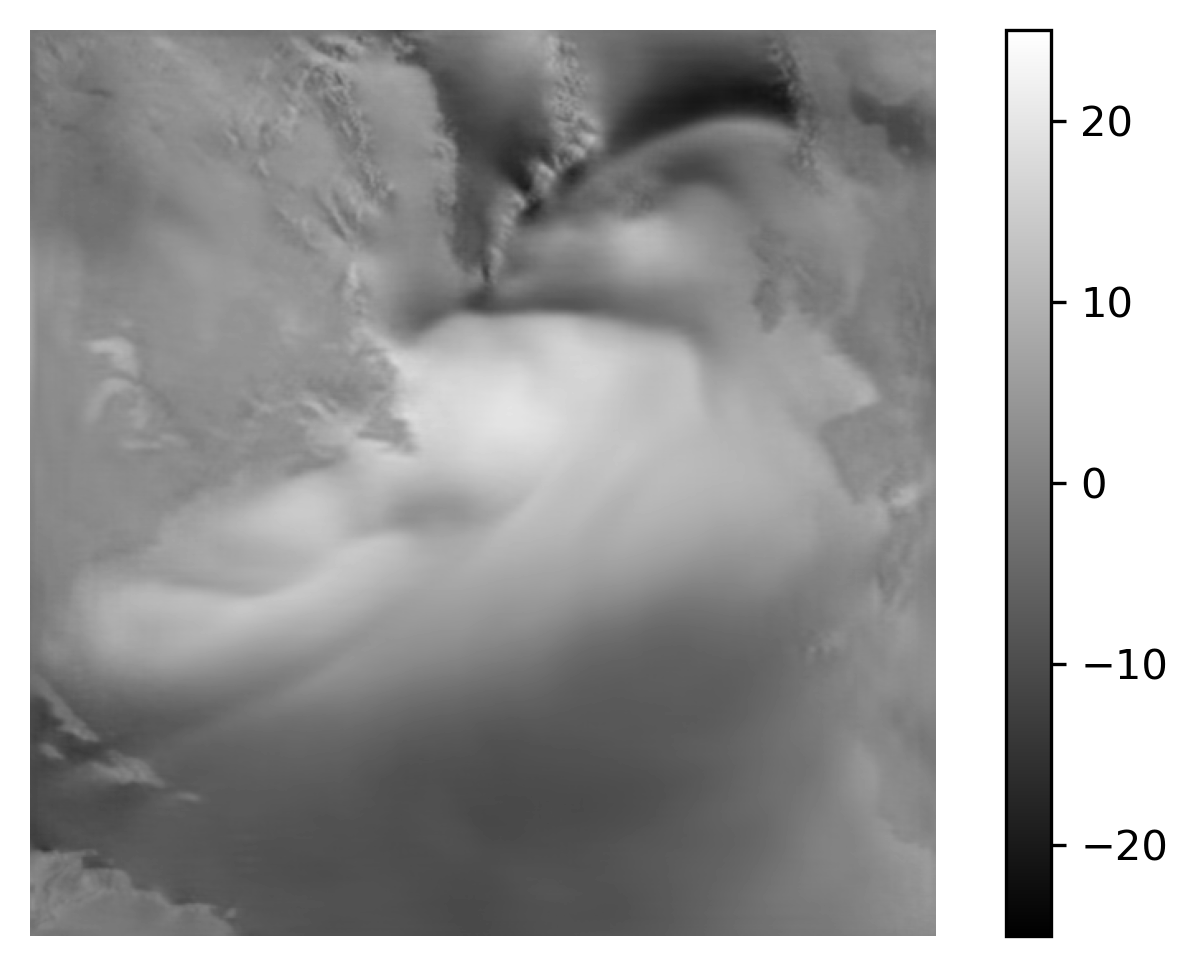

In [48]:
_ = plt.imshow(u_nn.cpu().detach().numpy(), cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

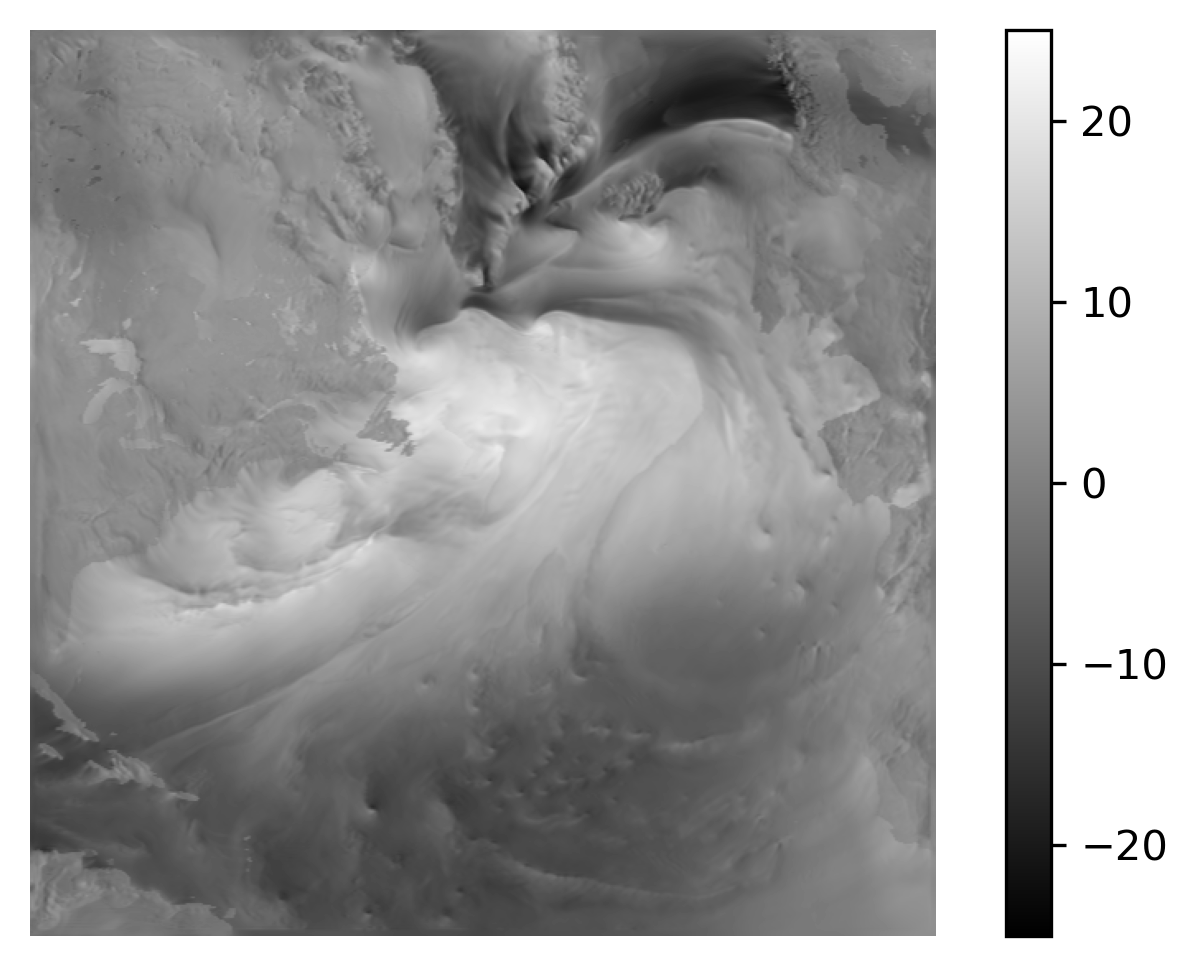

In [50]:
_ = plt.imshow(u_hr[0], cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

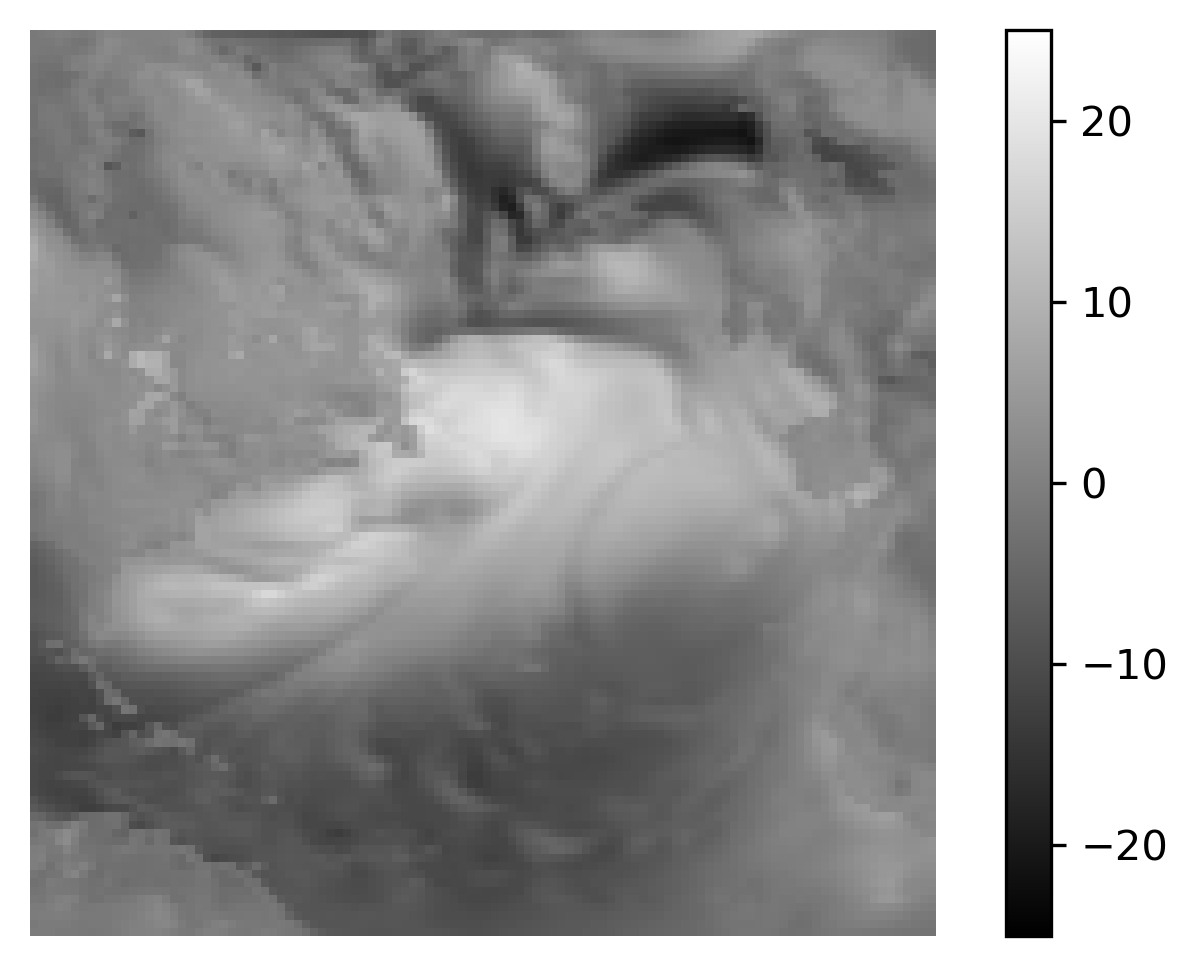

In [51]:
_ = plt.imshow(field_lr[0][0], cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

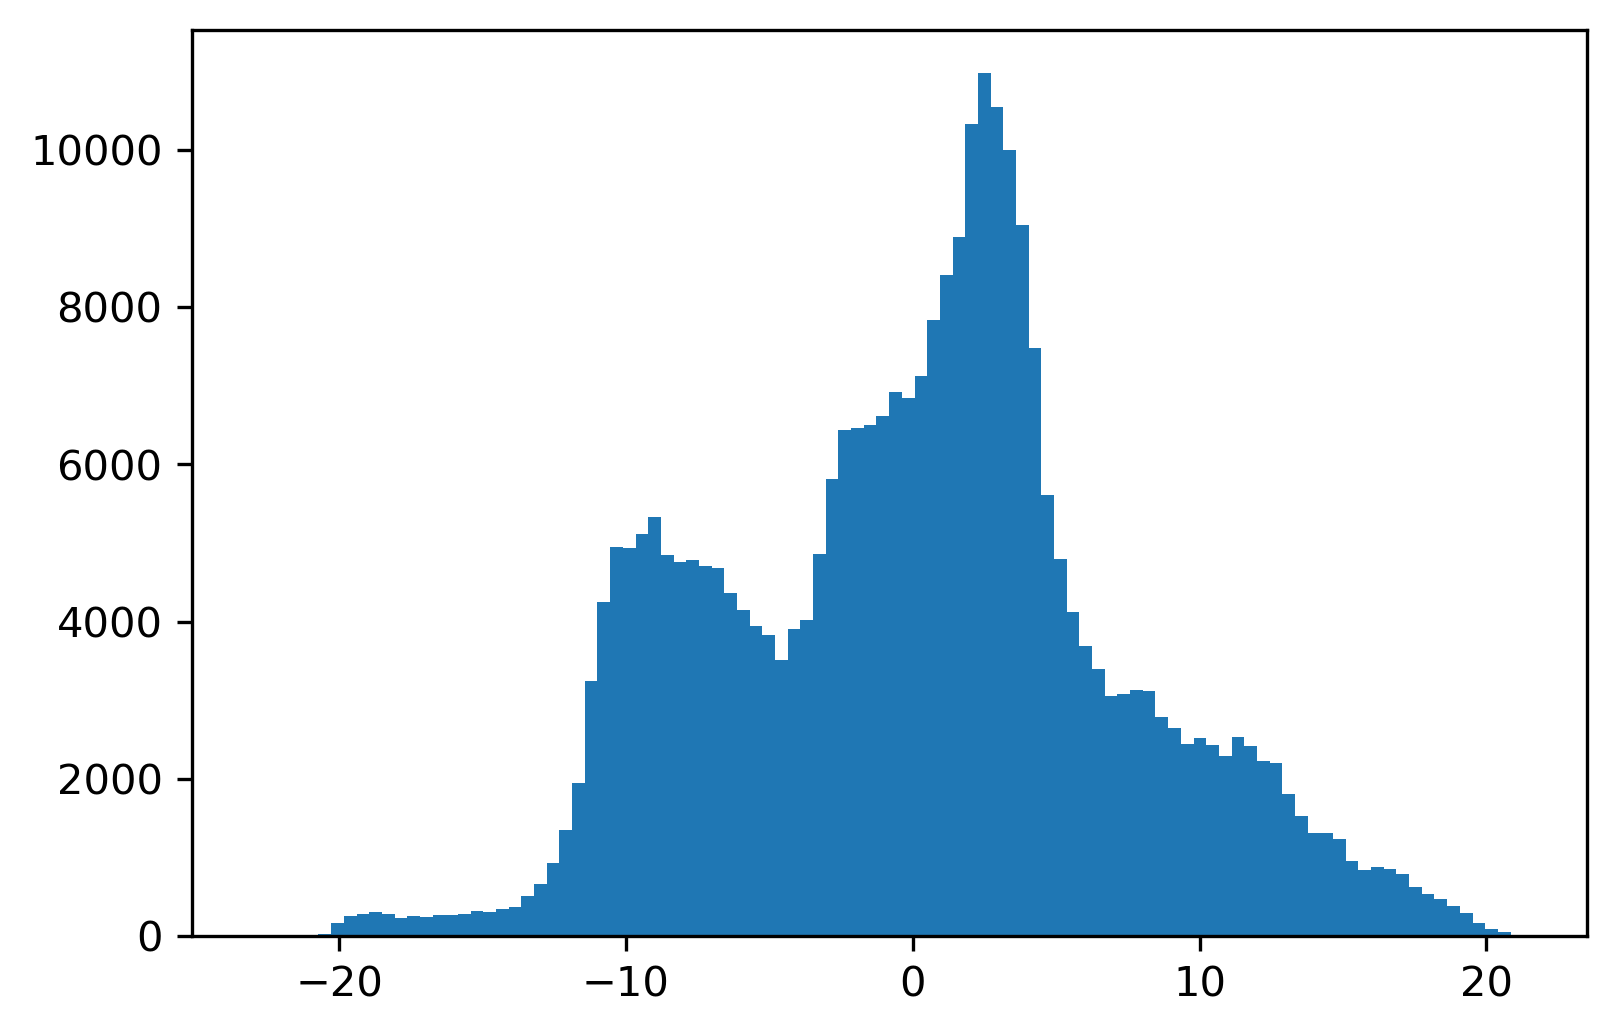

In [52]:
_ = plt.hist(u_hr[0].flatten(), bins = 100)
_ = plt.savefig("High.png")

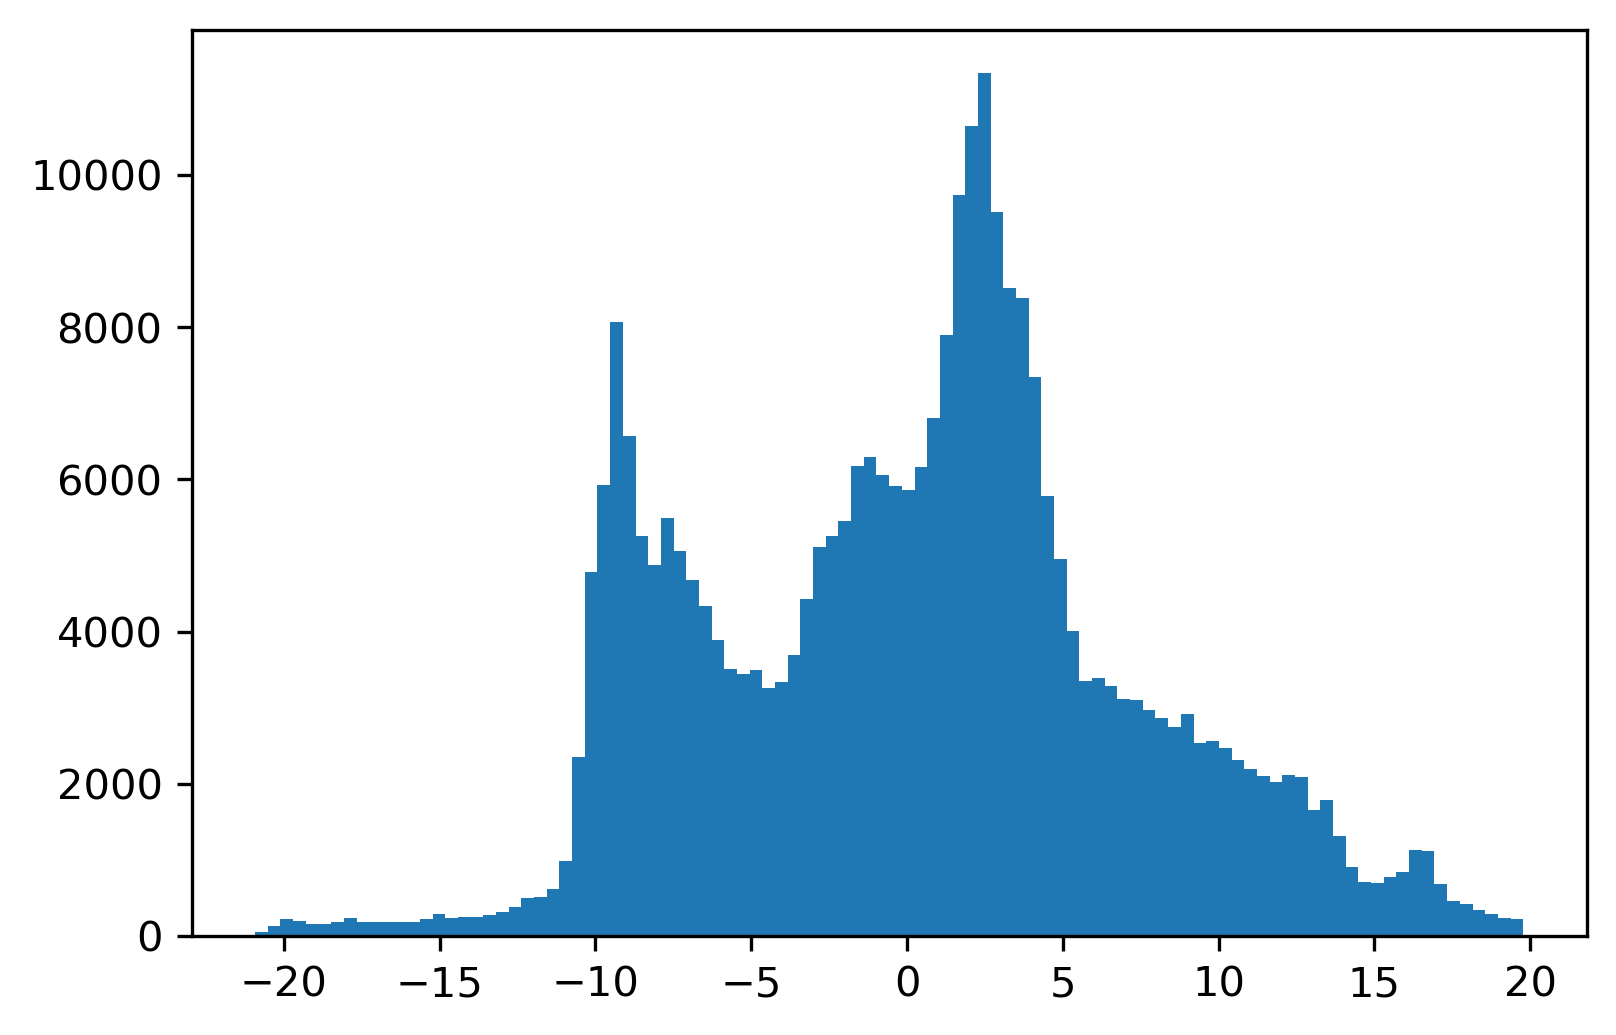

In [53]:
_ = plt.hist(u_nn.cpu().detach().numpy().flatten(), bins = 100)
_ = plt.savefig("NN.png")

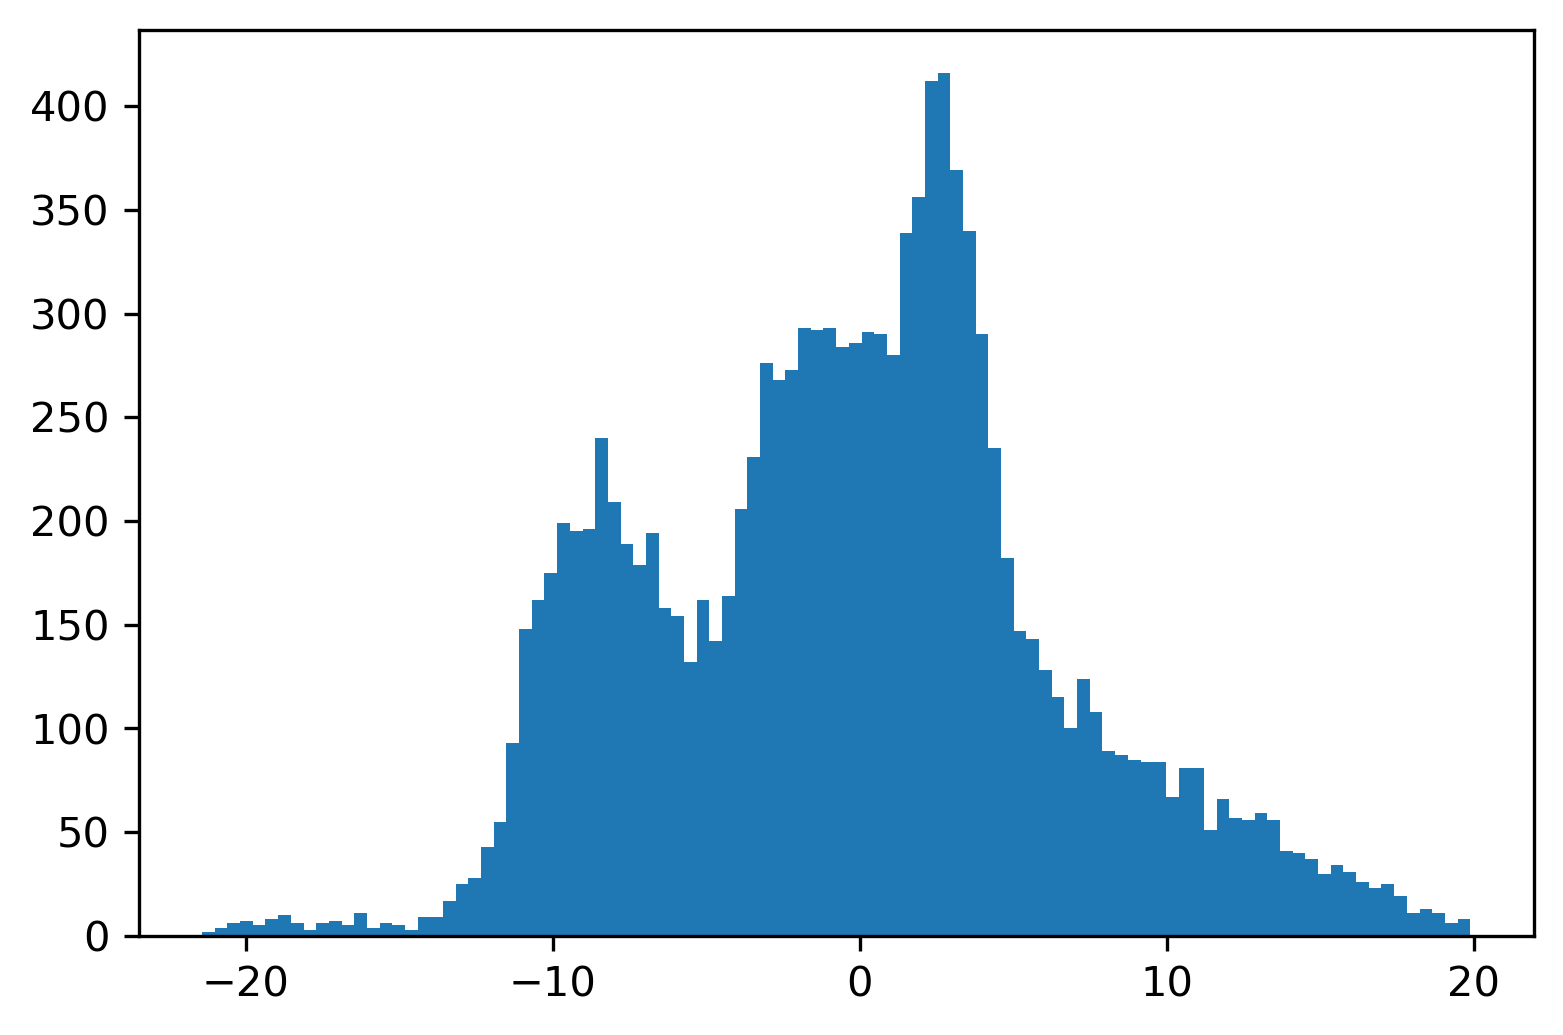

In [54]:
_ = plt.hist(field_lr[0][0].flatten(), bins = 100)
_ = plt.savefig("Low.png")